In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
import mnist_models

def transform(img):
    u = 33.3
    s = 76.8

    img = np.array(img, dtype=np.float32)
    img = (img-u)/s
    return torch.from_numpy(img)

def get_dataset(root, n):

    ds_train = torchvision.datasets.MNIST(root, train=True, transform=transform, download=False)
    ds_valid = torchvision.datasets.MNIST(root, train=False, transform=transform, download=False)

    indices = random.sample(range(len(ds_train)), n)

    # Extract random subset for training data
    ds_train.data = ds_train.data[indices]
    ds_train.targets = ds_train.targets[indices]

    return ds_train, ds_valid

def weight_stats(model):
    w = model.conv.weight.detach()
    m = w.abs().mean(dim=(1,2,3))
    s = w.abs().std(dim=(1,2,3))
    max = w.abs().amax(dim=(1,2,3))
    m_n = w.mean(dim=(1,2,3))

    plt.figure(figsize=(8,4))
    plt.plot(m, label='Average abs')
    plt.plot(s, label='Std abs')
    plt.plot(max, '-o', label='Max abs')
    plt.plot(m_n, label='Average')
    plt.legend()

root = 'K:/datasets/classification'
n = 5000
random.seed(42)

ds_train, ds_valid = get_dataset(root, n)

## Train networks

In [89]:
def train(model, ds_train, lr, bs, num_epochs, alpha, device):
    ce = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)
    model.to(device)

    dl = torch.utils.data.DataLoader(
        ds_train,
        batch_size=bs,
        shuffle=True,
    )

    logger = {'loss_entropy':[], 'loss_aux':[], 'acc':[]}
    for epoch in range(num_epochs):
        loss_entropy_s = 0
        loss_aux_s = 0
        model.train()
        for imgs, labels in dl:
            #imgs = torch.flatten(imgs, 1)
            imgs = imgs.to(device)
            labels = labels.to(device)
            imgs = imgs[:,None]
            ret = model.forward_train(imgs)
            res = ret['out']

            optimizer.zero_grad()
            loss_entropy = ce(res, labels)

            loss_aux = ret['pooled'].abs().mean()
            #loss_aux = ret['maps'].max(dim=3)[0].max(dim=2)[0].abs().mean()
            #loss_aux = model.conv.weight.abs().mean()
            #loss_aux = 0.

            (loss_entropy+alpha*loss_aux).backward()

            optimizer.step()
            
            loss_entropy_s += loss_entropy.item()*len(imgs)
            loss_aux_s += loss_aux.item()*len(imgs)

        loss_entropy_s = loss_entropy_s/len(ds_train)
        loss_aux_s = loss_aux_s/len(ds_train)

        model.eval()
        acc = 0
        with torch.no_grad():
            for imgs, labels in dl:
                imgs = imgs.to(device)
                labels = labels.to(device)
                #imgs = torch.flatten(imgs, 1)
                imgs = imgs[:,None]
                res = model(imgs)    
                preds = res.argmax(dim=1)
                acc += (preds==labels).sum().item()

        avg_acc = acc/len(ds_train)   

        logger['loss_entropy'].append(loss_entropy_s)
        logger['loss_aux'].append(loss_aux_s)
        logger['acc'].append(avg_acc)
        print(epoch, loss_entropy_s, loss_aux_s, 100*avg_acc)

    model.to('cpu')

    return logger

lr = 0.04
bs = 16
num_epochs = 10
alpha = 1.
torch.manual_seed(43)

model = mnist_models.CNN(max_pool=True)
logger = train(model, ds_train, lr, bs, num_epochs, alpha=alpha, device='cuda')
logger = train(model, ds_train, lr=0.01, bs=bs, num_epochs=20, alpha=alpha, device='cuda') 

0 1.8387860767364501 0.2704417997926474 54.17999999999999
1 0.8882599863052368 0.48400692625045777 74.24
2 0.6700715396404266 0.4918758222103119 74.2
3 0.6155454612493515 0.49875733675956724 66.74
4 0.585585540485382 0.5046644608020783 76.68
5 0.5499742879867554 0.5070206300735474 79.86
6 0.5268529480695725 0.5104261806488037 74.66000000000001
7 0.500146966958046 0.5125509789466858 87.18
8 0.4855027223825455 0.513446768283844 87.1
9 0.474671050798893 0.522224037361145 88.1
0 0.3062379828095436 0.46500451240539553 93.44
1 0.30041850156784056 0.4248647914886475 93.56
2 0.3004574043512344 0.40664729952812195 93.34
3 0.30343407229185104 0.393632386302948 92.52
4 0.3035154762983322 0.38468448839187624 89.02
5 0.30121384663581846 0.3783045419216156 91.8
6 0.297085379242897 0.3726036805152893 93.42
7 0.29991480915546415 0.36738924703598025 92.80000000000001
8 0.2952615505337715 0.3647174570560455 94.02000000000001
9 0.2912263855695724 0.3603923491477966 93.5
10 0.29331915587186813 0.358279947

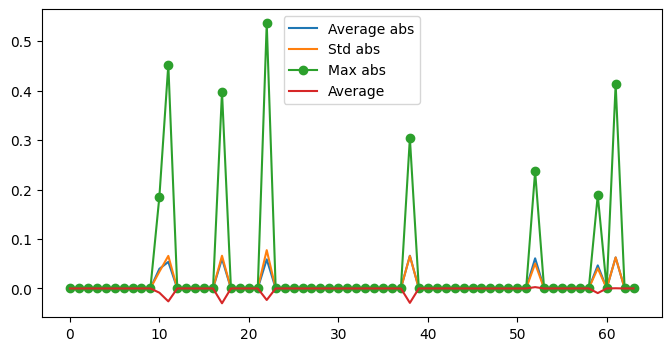

In [90]:
#19 0.2760041542649269 0.34017285356521604 93.67999999999999
weight_stats(model)

In [81]:
torch.save(model.state_dict(), 'models/cnn_sparse2.pt')